#Data Loading/Fetching

In [ ]:
!git clone https://github.com/planetlabs/planet-amazon-deforestation

Cloning into 'planet-amazon-deforestation'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.


In [ ]:
import sys

sys.path.append('/content/planet-amazon-deforestation/img')

In [ ]:
!pip install --upgrade tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 7.4 MB/s eta 0:00:00


In [ ]:
import tf_slim as slim

In [ ]:
import os
import cv2 as cv
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Import into files "train_v2.csv", "test_v2_file_mapping.csv", "sample_submission_v2.csv"

In [ ]:
#paths from kaggle data
train_path = '/content/train_v2.csv'
test_path = '/content/test_v2_file_mapping.csv'
sample_path = '/content/sample_submission_v2.csv'

In [ ]:
labels_tr_df = pd.read_csv(train_path)
labels_tr_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
labels_tst_df = pd.read_csv(test_path)
labels_tst_df.head()

,old,new
0,file_4158.tif,file_18830.tif
1,file_1668.tif,file_19164.tif
2,file_2411.tif,file_15749.tif
3,file_16047.tif,file_7531.tif
4,file_1271.tif,file_18347.tif


In [ ]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_tr_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))
images_title = [labels_tr_df[labels_tr_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg'  for i, label in enumerate(labels_set)]
     

There is 17 unique labels including {'road', 'conventional_mine', 'blooming', 'primary', 'cloudy', 'partly_cloudy', 'water', 'bare_ground', 'cultivation', 'blow_down', 'clear', 'haze', 'habitation', 'slash_burn', 'artisinal_mine', 'selective_logging', 'agriculture'}


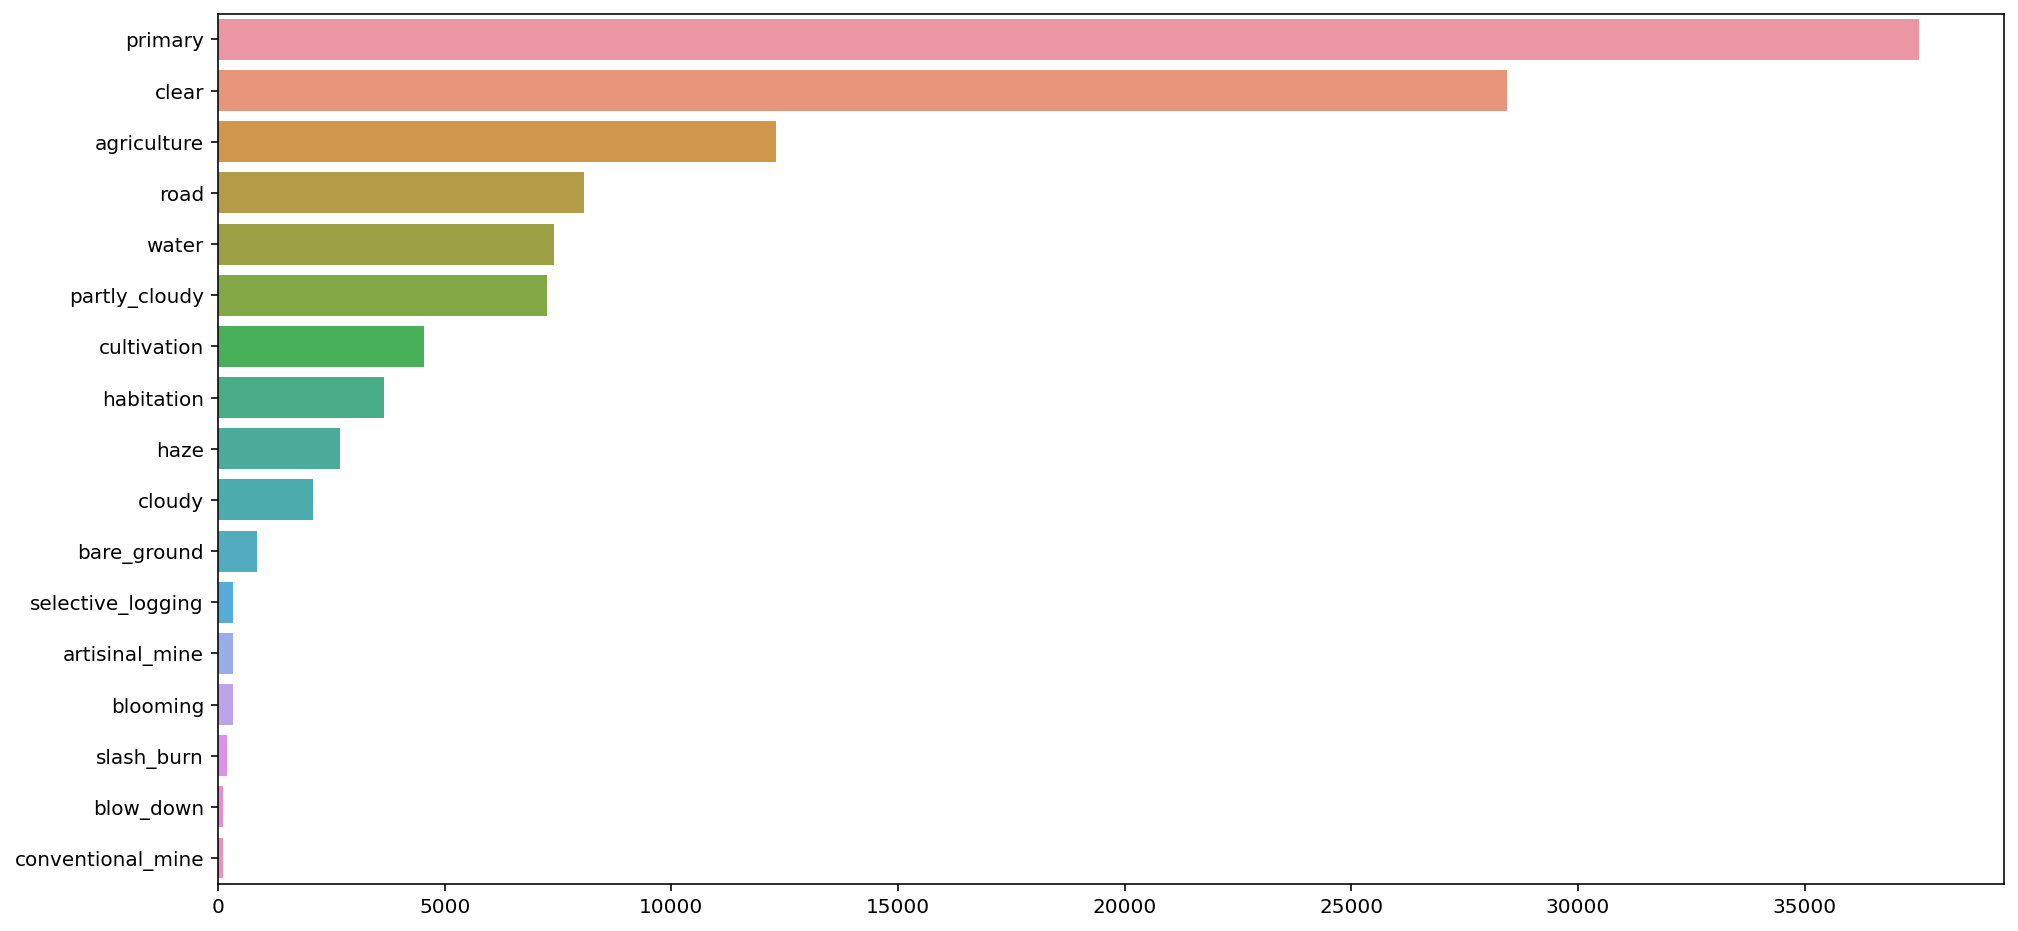

In [ ]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() 
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

As expected, some classes are largely representated whereas some are barely present in this dataset. There is a risk that our model barely learn the rare classes or even to exclude them from the training data upon splitting between training and validating sets.

In [ ]:
img_resize = (74, 74)  # nova velikost potrebna pro XCeption model
validation_split_size = 0.2
epochs = 20
batch_size = 128

#Data Preprocessing

In [ ]:
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
!pip install -q torchsummary --user
from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


##Class visualisation

Let's now observe each label invidually. Each image is mapped to a list of labels, with a total of 17 different labels. All 17 labels are "almost" independent, meaning that primary can be found along with slash burn. I said "almost" because cloudy affects visibility, so that no other label can be found in the same image.

For sake of clarity, I only displayed one label per image on the figure below. When images are associated to multiple labels, I displayed them multiple times (e.g. primary and haze).

In [ ]:
!7z e train-jpg.tar.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 629296207 bytes (601 MiB)

Extracting archive: train-jpg.tar.7z
--
Path = train-jpg.tar.7z
Type = 7z
Physical Size = 629296207
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train-jpg.tar                      1% - train-jpg.tar                      2% - train-jpg.tar                      3% - train-jpg.tar                      4% - train-jpg.tar                      5% - train-jpg.tar                      6% - train-jpg.tar    

In [ ]:
%cd /content/
!7z x -so train-jpg.tar.7z | tar xf - -C /content/

/content


In [ ]:
path = "/content/"
path_train_jpg = os.path.join(path, "train-jpg")

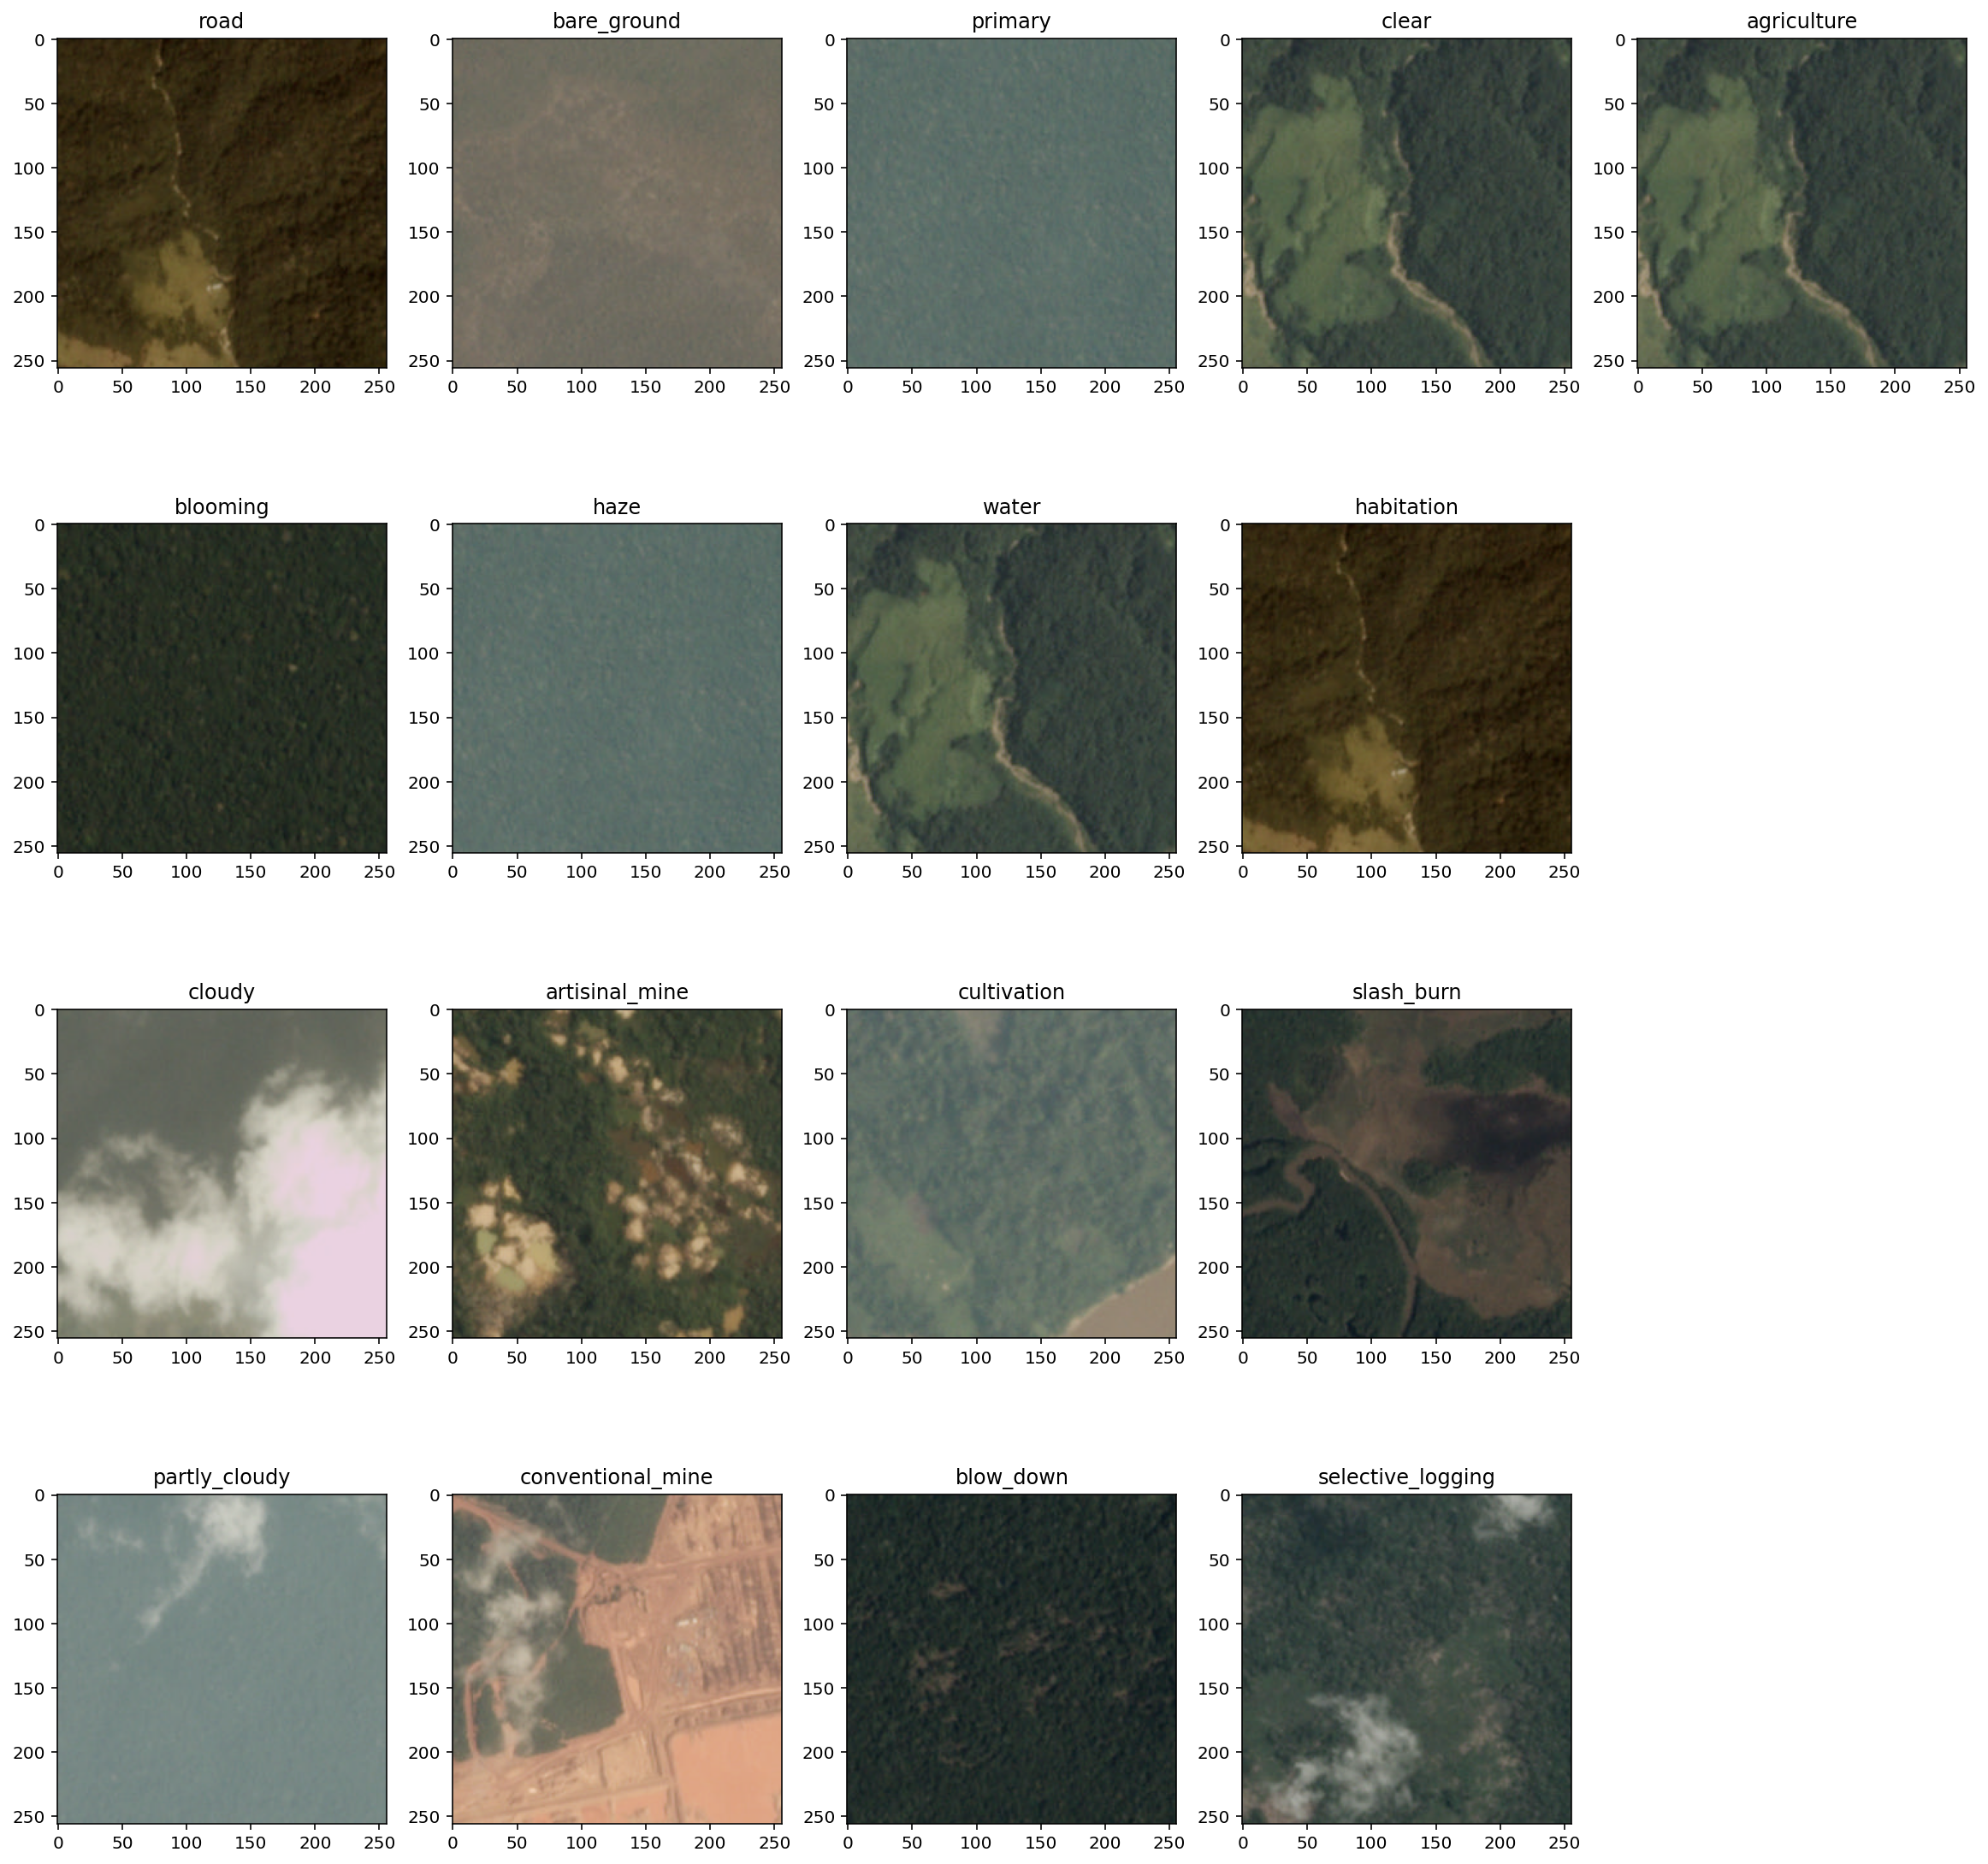

In [ ]:
all_tags = list(set(labels_set))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = labels_tr_df.loc[labels_tr_df.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train_jpg, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

We can make few remarks here:

Some labels like "water" or "road" are challenging to differenciate
Some rare labels like selecting logging and blooming are also hard to discriminate, and are barely visible at all
Strong correlations can be expected between labels like habitation, road and cultivations

##Transformations

Resnet18 needs input shape that are multiple of 32 and in our case we have input of size 256. From 256, the closest multiple of 32 is 224.

Therefore, we rescale our input data using this multiple, and we also normalize our dataset based on resnet pretrained mean and standard deviation intensity values. ToTensor() is useful to normalize our image values from 0-255 range to 0-1 range.

In [ ]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      )
    ])
    return transform_train, transform_val